# Рекомендация тарифов

## Обзор данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
from sklearn.linear_model import LogisticRegression 
from sklearn.datasets import load_iris

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
# посмотрим на распределение тарифов по датасету
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [6]:
# посмотрим отношение количества строк с 0 к 1 is_ultra
rat = len(df.loc[df['is_ultra']==0])/len(df.loc[df['is_ultra']==1])
rat

2.2629441624365483

Строк с тарифом Ультра (0) гораздо больше, чем строк с тарифом Смарт (1).

In [7]:
# Данные нужно разбить на три части: обучающую, валидационную и тестовую в соотношении 3:1:1.
# обучающая выборка 60%, валидационная выборка 20%, тестовая выборка 20%
train, check = train_test_split(df, train_size=0.6, random_state=12345, stratify = df['is_ultra'])

In [8]:
valid, test = train_test_split(check, test_size=0.5, random_state=12345, stratify = check['is_ultra'])

In [9]:
train['is_ultra'].value_counts()

0    1337
1     591
Name: is_ultra, dtype: int64

In [10]:
# проверим как разбили датасет
display(train.shape)
display(valid.shape)
display(test.shape)

(1928, 5)

(643, 5)

(643, 5)

Целевым признаком в нашем случае является столбец 'is_ultra'. В нем содержится информация, каким тарифным планом пользуется клиент. Данный признак является категориальным. 
В исследовании будем использовать следующие модели машинного обучения:

- Решающее дерево
- Случайный лес 
- Логистическая регрессия

Каждую модель обучим на обучающем наборе и проверим на валидационной выборке. Таким образом определим лучшую модель.

In [11]:
# объявим переменные features и target для каждой выборки
features_train = train.drop(['is_ultra'], axis=1)
target_train = train['is_ultra']

features_valid = valid.drop(['is_ultra'], axis=1)
target_valid = valid['is_ultra']

features_test = test.drop(['is_ultra'], axis=1)
target_test = test['is_ultra']

## Модель решающее дерево

Построим модель "Решающего дерева". Гиперпараметр max_depth(максимальная глубина) будем изменять в пределах от 1 до 10 в цикле, для того, чтобы подобрать наилучшую модель. 

In [12]:
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # создаем модель
    model.fit(features_train, target_train) # обучаем модель
    predictions_valid = model.predict(features_valid) #находим предсказания по валидационной выборке. 
    
    
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

max_depth = 1 : 0.7402799377916018
max_depth = 2 : 0.7729393468118196
max_depth = 3 : 0.7776049766718507
max_depth = 4 : 0.7542768273716952
max_depth = 5 : 0.7853810264385692
max_depth = 6 : 0.7744945567651633
max_depth = 7 : 0.7869362363919129
max_depth = 8 : 0.80248833592535
max_depth = 9 : 0.7822706065318819
max_depth = 10 : 0.7729393468118196


Максимальная доля правильных ответов составляет 80% при max_depth=8. 

In [13]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=8) # сохраним модель решающего дерева

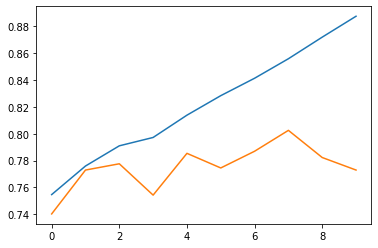

In [14]:
train_acc = []
valid_acc = []

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid) 
    

    predictions_train = model.predict(features_train)

    acc_valid = accuracy_score(target_valid, predictions_valid)
    acc_train = accuracy_score(target_train, predictions_train)
  
    train_acc.append(acc_train)
    valid_acc.append(acc_valid)
    

import matplotlib.pyplot as plt
plt.plot(train_acc)
plt.plot(valid_acc)
plt.show()

## Модель случайный лес

In [15]:
# соберем значения accuracy и гиперпараметров в списки, из которых потом создадим датафрейм
accuracy_list = []
max_depth_list = []
estim_list = []

for md in range(1, 17):
    for est in range(2, 50):
        model_rf = RandomForestClassifier(random_state=12345, max_depth=md, n_estimators=est)
        
        model_rf.fit(features_train, target_train)
        
        predictions_rf = model_rf.predict(features_valid)
        
        accuracy_rf = round(accuracy_score(target_valid, predictions_rf), 4)
        
        accuracy_list.append(accuracy_rf)
        max_depth_list.append(md)
        estim_list.append(est)

In [16]:
# собираем все списки в один
result_list = [max_depth_list, estim_list, accuracy_list]

# создаем датафрейм
df_random_forest = pd.DataFrame({'max_depth':max_depth_list, 'n_estimators':estim_list, 'accuracy':accuracy_list})

# из которого теперь легко вычленить интересующую нас информацию
# ввиду строки с максимальным значением accuracy и соответствующих гиперпараметров
display(df_random_forest[df_random_forest['accuracy']==df_random_forest['accuracy'].max()])

,max_depth,n_estimators,accuracy
421,9,39,0.8227


Максимальная доля правильных ответов составила 82%, при max_depth=9, n_etimators=39. 

In [17]:
best_model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=39) # сохраним лучшу модель RF
best_model.fit(features_train, target_train)

RandomForestClassifier(max_depth=9, n_estimators=39, random_state=12345)

In [18]:
from sklearn.ensemble import RandomForestClassifier
    
from sklearn.model_selection import GridSearchCV
    
X_train = df.drop('is_ultra', axis=1)
    
y_train = df['is_ultra']
    
clf = RandomForestClassifier() 
    
parametrs = { 'n_estimators': range (10, 11, 1), 
    
              'max_depth': range (1,6, 2), 
    
              'min_samples_leaf': range (1,2), 
    
              'min_samples_split': range (2,4,2) } 
    
grid = GridSearchCV(clf, parametrs, cv=5) 
    
grid.fit(X_train, y_train) 
    
grid.best_params_ 

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

## Модель логистическая регрессия 

In [19]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_lr.fit(features_train, target_train) 
predictions_lr = model_lr.predict(features_valid)
accuracy_lr = round(accuracy_score(target_valid, predictions_lr), 4)
accuracy_lr

0.7387

Модель логистической регрессии показывает самый худший результат, почти 74% правильных ответов.

## Проверка качества модели на тестовой выборке

Проверим как ведет себя лучшая модель случайного леса на тестовой выборке.

In [20]:
predictions_test = best_model.predict(features_test)

accuracy_test = accuracy_score(target_test, predictions_test)
accuracy_test

0.8118195956454122

81% правильных ответов. 

In [21]:
best_model.fit(pd.concat([features_valid, features_train]), pd.concat([target_valid, target_train]))

RandomForestClassifier(max_depth=9, n_estimators=39, random_state=12345)

In [22]:
predictions_test = best_model.predict(features_test)

accuracy_test = accuracy_score(target_test, predictions_test)
accuracy_test

0.838258164852255

## Проверка модели на вменяемость

Чтобы проверить модель на вменяемость в задачах классификации, нужно сравнить её со случайной. 

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
model_dc = DummyClassifier().fit(features_train, target_train)
display(model_dc.score(features_test, target_test))

0.6936236391912908

# Общий вывод

Данные были разделены на ри выборки: обучающую, валидационную и тестовую в соотношении 60% 20% 20% соответственно. 
На основании выборок были обучены три модели: решющее дерево, случайный лес и логистическая регрессия. У модели решающий лес самый большой показатель правильных ответов, который составляет 82%. Проверка модели на тестовой выборке дала результат в 81%.  Самый низкий показатель у модели логистической регрессии, процент правильных ответов составил почти 74%. 
Соответственно модель случайного леса лучше подходит для задачи заказчика. 